#Colab 0) 드라이브 마운트 + 경로 설정


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# ✅ 너희 데이터 루트(필요시 수정)
DATA_ROOT = "/content/drive/MyDrive/3.개방데이터/1.데이터"

TRAIN_ROOT = f"{DATA_ROOT}/Training"
VAL_ROOT   = f"{DATA_ROOT}/Validation"
OTHER_ROOT = f"{DATA_ROOT}/Other"

print("DATA_ROOT:", DATA_ROOT)


Mounted at /content/drive
DATA_ROOT: /content/drive/MyDrive/3.개방데이터/1.데이터


#1) (필수) 데이터 폴더 구조 점검

In [ ]:
import os, glob

def ls(path, n=20):
    items = sorted(os.listdir(path))
    print(f"[{path}] count={len(items)} sample={items[:n]}")
    return items

assert os.path.exists(DATA_ROOT), "DATA_ROOT 경로가 존재하지 않음"
ls(DATA_ROOT)
ls(TRAIN_ROOT)
ls(VAL_ROOT)
ls(OTHER_ROOT)


[/content/drive/MyDrive/3.개방데이터/1.데이터] count=3 sample=['Other', 'Training', 'Validation']
[/content/drive/MyDrive/3.개방데이터/1.데이터/Training] count=2 sample=['01.원천데이터', '02.라벨링데이터']
[/content/drive/MyDrive/3.개방데이터/1.데이터/Validation] count=2 sample=['01.원천데이터', '02.라벨링데이터']
[/content/drive/MyDrive/3.개방데이터/1.데이터/Other] count=1 sample=['Other.zip.part0']


['Other.zip.part0']

#2) .zip.part* → 진짜 .zip 합치기 (Training/Validation 모두)




`TL_*.zip.part0`, `TS_*.zip.part0` 이런 파일들을 찾아서
같은 prefix의 .part0~들을 순서대로 concat 해서 .zip으로 만듦.

In [ ]:
import re
from pathlib import Path

def find_zip_parts(root_dir):
    # *.zip.part0 / *.zip.part1 ... 찾아서 그룹핑
    part_files = glob.glob(os.path.join(root_dir, "**", "*.zip.part*"), recursive=True)
    groups = {}
    for p in part_files:
        # .../TL_xxx.zip.part0
        m = re.match(r"^(.*\.zip)\.part(\d+)$", p)
        if not m:
            continue
        base_zip = m.group(1)
        part_no = int(m.group(2))
        groups.setdefault(base_zip, []).append((part_no, p))
    return groups

def build_zips_from_parts(groups, overwrite=False, sample_test=3):
    built = []
    for base_zip, parts in groups.items():
        parts = sorted(parts, key=lambda x: x[0])
        out_path = base_zip  # ...xxx.zip
        if os.path.exists(out_path) and not overwrite:
            built.append(out_path)
            continue

        Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
        with open(out_path, "wb") as w:
            for _, part_path in parts:
                with open(part_path, "rb") as r:
                    w.write(r.read())
        built.append(out_path)

    print("built zip count =", len(built))
    print("sample:", [os.path.basename(x) for x in built[:10]])
    return built

# Training / Validation 각각 수행
train_groups = find_zip_parts(TRAIN_ROOT)
val_groups   = find_zip_parts(VAL_ROOT)

print("Training part groups:", len(train_groups))
print("Validation part groups:", len(val_groups))

train_zips = build_zips_from_parts(train_groups, overwrite=False)
val_zips   = build_zips_from_parts(val_groups, overwrite=False)


Training part groups: 606
Validation part groups: 76
built zip count = 606
sample: ['TL_oht_16_oht16_0920_1756.zip', 'TL_oht_15_oht15_0829_0605.zip', 'TL_oht_16_oht16_0827_0208.zip', 'TL_oht_16_oht16_0827_0434.zip', 'TL_oht_15_oht15_0827_0708.zip', 'TL_oht_15_oht15_0920_0332.zip', 'TL_oht_16_oht16_0827_0219.zip', 'TL_oht_15_oht15_0826_2312.zip', 'TL_oht_16_oht16_0827_0713.zip', 'TL_oht_16_oht16_0826_1829.zip']
built zip count = 76
sample: ['VS_oht_18_oht18_0920_1828.zip', 'VS_oht_18_oht18_0902_1304.zip', 'VS_oht_18_oht18_0920_0412.zip', 'VS_oht_18_oht18_0920_0939.zip', 'VS_oht_18_oht18_0827_0743.zip', 'VS_oht_18_oht18_0902_0245.zip', 'VS_oht_18_oht18_0827_0454.zip', 'VS_oht_18_oht18_0827_0256.zip', 'VS_oht_18_oht18_0827_0227.zip', 'VS_oht_18_oht18_0826_2155.zip']


In [ ]:
!pip -q install tqdm
from tqdm.auto import tqdm


#3) 만들어진 zip이 “진짜 zip”인지 샘플로 열어보기

In [ ]:
import zipfile, random

def zip_open_test(zip_paths, k=3, tag=""):
    picks = random.sample(zip_paths, min(k, len(zip_paths)))
    print(f"[{tag}] zip open test:")
    for zp in picks:
        ok = True
        try:
            with zipfile.ZipFile(zp, "r") as z:
                _ = z.namelist()[:5]
        except Exception as e:
            ok = False
        print(" -", os.path.basename(zp), "=>", ok)

zip_open_test(train_zips, 3, "Training")
zip_open_test(val_zips, 3, "Validation")


[Training] zip open test:
 - TL_oht_16_oht16_0902_1241.zip => True
 - TS_agv_15_agv15_0902_1032.zip => True
 - TS_oht_09_oht09_0920_1952.zip => True
[Validation] zip open test:
 - VS_oht_17_oht17_0920_0359.zip => True
 - VS_agv_17_agv17_0902_1908.zip => True
 - VL_oht_18_oht18_0826_1856.zip => True


In [ ]:
import zipfile, random

def zip_open_test(zip_paths, k=10, tag=""):
    k = min(k, len(zip_paths))
    picks = random.sample(zip_paths, k)
    ok_cnt = 0
    for zp in tqdm(picks, desc=f"[{tag}] zip open test", unit="zip"):
        try:
            with zipfile.ZipFile(zp, "r") as z:
                _ = z.namelist()[:5]
            ok_cnt += 1
        except:
            pass
    print(f"[{tag}] open ok: {ok_cnt}/{k}")


#4) TL/TS, VL/VS 분류 + 내부 파일 확장자 확인

In [ ]:
from collections import Counter

def split_by_prefix(zip_paths):
    buckets = {"TL":[], "TS":[], "VL":[], "VS":[], "OTHER":[]}
    for p in zip_paths:
        bn = os.path.basename(p)
        pref = bn[:2]
        if pref in buckets:
            buckets[pref].append(p)
        else:
            buckets["OTHER"].append(p)
    return buckets

train_b = split_by_prefix(train_zips)
val_b   = split_by_prefix(val_zips)

print("Train TL:", len(train_b["TL"]), "| TS:", len(train_b["TS"]))
print("Val   VL:", len(val_b["VL"]), "| VS:", len(val_b["VS"]))

def inner_ext_stats(zip_path, n_preview=3):
    with zipfile.ZipFile(zip_path, "r") as z:
        names = z.namelist()
    exts = [os.path.splitext(x)[1].lower() for x in names if not x.endswith("/")]
    c = Counter(exts)
    return c, names[:n_preview]

# 샘플 확인
for k in ["TL","TS"]:
    if train_b[k]:
        c, names = inner_ext_stats(train_b[k][0])
        print(f"[{k} sample inner ext]", train_b[k][0].split("/")[-1], c.most_common(5))
        print(" file sample:", names[:10])

for k in ["VL","VS"]:
    if val_b[k]:
        c, names = inner_ext_stats(val_b[k][0])
        print(f"[{k} sample inner ext]", val_b[k][0].split("/")[-1], c.most_common(5))
        print(" file sample:", names[:10])


Train TL: 303 | TS: 303
Val   VL: 38 | VS: 38
[TL sample inner ext] TL_oht_16_oht16_0920_1756.zip [('.json', 301)]
 file sample: ['/oht16_0920_175612.json', '/oht16_0920_175624.json', '/oht16_0920_175639.json']
[TS sample inner ext] TS_oht_16_oht16_0920_1756.zip [('.csv', 301), ('.bin', 301)]
 file sample: ['/oht16_0920_175613.csv', '/oht16_0920_175610.csv', '/oht16_0920_175614.csv']
[VL sample inner ext] VL_oht_18_oht18_0920_1828.zip [('.json', 301)]
 file sample: ['/oht18_0920_182804.json', '/oht18_0920_182805.json', '/oht18_0920_182812.json']
[VS sample inner ext] VS_oht_18_oht18_0920_1828.zip [('.bin', 301), ('.csv', 301)]
 file sample: ['/oht18_0920_182819.bin', '/oht18_0920_182813.bin', '/oht18_0920_182807.bin']


#5) zip 안의 “센서 csv”와 “라벨 json”을 sample_key로 매칭하기


* TS/VS zip에는 ...csv가 있고, 파일명에 agv17_0902_103911.csv처럼 sample_key가 들어있음

* TL/VL zip에는 ...json이 있고, agv17_0902_103915.json 같은 같은 sample_key가 들어있음

* 그래서 (device_id, sample_key) 단위로 센서와 라벨을 조인함

In [ ]:
import pandas as pd
import numpy as np
import re, os, zipfile

def parse_zip_meta(zip_path):
    bn = os.path.basename(zip_path)
    m = re.match(r"^[TV][SL]_(agv|oht)_(\d+)_", bn)
    if not m:
        return None, None
    return m.group(1), int(m.group(2))

def build_index_from_zips(zip_paths, want_ext, tag=""):
    rows = []
    for zp in tqdm(zip_paths, desc=f"[{tag}] index {want_ext}", unit="zip"):
        eq_type, eq_id = parse_zip_meta(zp)
        if eq_type is None:
            continue
        with zipfile.ZipFile(zp, "r") as z:
            names = z.namelist()
        for name in names:
            if name.endswith("/") or (not name.lower().endswith(want_ext)):
                continue
            base = os.path.basename(name)
            sample_key = os.path.splitext(base)[0]
            rows.append({
                "zip_path": zp,
                "inner_path": name,
                "equipment_type": eq_type,
                "equipment_id": eq_id,
                "sample_key": sample_key,
                "zip_name": os.path.basename(zp),
            })
    return pd.DataFrame(rows)


In [ ]:
import pandas as pd
import numpy as np
import json

def parse_zip_meta(zip_path):
    """
    zip 파일명에서 equipment_type(oht/agv), equipment_id(숫자)를 파싱
    예: TS_agv_11_agv11_0903_1206.zip
    """
    bn = os.path.basename(zip_path)
    # TS_agv_11_agv11_0903_1206.zip
    m = re.match(r"^[TV][SL]_(agv|oht)_(\d+)_", bn)
    if not m:
        return None, None
    eq_type = m.group(1)
    eq_id = int(m.group(2))
    return eq_type, eq_id

def build_index_from_zips(zip_paths, want_ext):
    """
    zip_paths에서 want_ext(.csv/.json) 파일의 sample_key를 추출해 인덱스 생성
    return: list of dict
    """
    rows = []
    for zp in zip_paths:
        eq_type, eq_id = parse_zip_meta(zp)
        if eq_type is None:
            continue
        with zipfile.ZipFile(zp, "r") as z:
            for name in z.namelist():
                if name.endswith("/") or (not name.lower().endswith(want_ext)):
                    continue
                base = os.path.basename(name)
                sample_key = os.path.splitext(base)[0]  # agv17_0902_103915
                rows.append({
                    "zip_path": zp,
                    "inner_path": name,
                    "equipment_type": eq_type,
                    "equipment_id": eq_id,
                    "sample_key": sample_key,
                    "zip_name": os.path.basename(zp),
                })
    return pd.DataFrame(rows)

# 센서(csv): TS + VS
df_ts = build_index_from_zips(train_b["TS"], ".csv")
df_vs = build_index_from_zips(val_b["VS"], ".csv")
df_sensor_idx = pd.concat([df_ts, df_vs], ignore_index=True)

# 라벨(json): TL + VL
df_tl = build_index_from_zips(train_b["TL"], ".json")
df_vl = build_index_from_zips(val_b["VL"], ".json")
df_label_idx = pd.concat([df_tl, df_vl], ignore_index=True)

print("sensor_idx:", df_sensor_idx.shape, "label_idx:", df_label_idx.shape)
display(df_sensor_idx.head(3))
display(df_label_idx.head(3))


sensor_idx: (111870, 6) label_idx: (111870, 6)


,zip_path,inner_path,equipment_type,equipment_id,sample_key,zip_name
0,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175613.csv,oht,16,oht16_0920_175613,TS_oht_16_oht16_0920_1756.zip
1,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175610.csv,oht,16,oht16_0920_175610,TS_oht_16_oht16_0920_1756.zip
2,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175614.csv,oht,16,oht16_0920_175614,TS_oht_16_oht16_0920_1756.zip


,zip_path,inner_path,equipment_type,equipment_id,sample_key,zip_name
0,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175612.json,oht,16,oht16_0920_175612,TL_oht_16_oht16_0920_1756.zip
1,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175624.json,oht,16,oht16_0920_175624,TL_oht_16_oht16_0920_1756.zip
2,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175639.json,oht,16,oht16_0920_175639,TL_oht_16_oht16_0920_1756.zip


# 6) 센서(csv) + 라벨(json) 조인해서 “전체 레코드” 만들기

* 센서 파일에서 필요한 컬럼만 읽어오기: NTC, PM1.0, PM2.5, PM10, CT1~CT4

* 라벨 json에서 annotations -> tagging -> state를 읽어서 label로 만들기

In [ ]:
def read_csv_from_zip(zip_path, inner_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        with z.open(inner_path) as f:
            df = pd.read_csv(f)
    return df

def read_json_from_zip(zip_path, inner_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        with z.open(inner_path) as f:
            data = json.load(f)
    return data

def extract_label_from_json(data):
    # annotations: [{'tagging': [{'annotation_type':'tagging','state':'0'}]}]
    try:
        ann = data.get("annotations", [])
        if not ann:
            return None
        tagging = ann[0].get("tagging", [])
        if not tagging:
            return None
        state = tagging[0].get("state", None)
        if state is None:
            return None
        return int(state)
    except Exception:
        return None

SENSOR_COLS = ["NTC","PM1.0","PM2.5","PM10","CT1","CT2","CT3","CT4"]

# 조인 키: equipment_type, equipment_id, sample_key
join_cols = ["equipment_type","equipment_id","sample_key"]
merged = df_sensor_idx.merge(df_label_idx, on=join_cols, how="inner", suffixes=("_sensor","_label"))
print("merged rows:", merged.shape)
display(merged.head(3))

# 진행 로그 포함 레코드 생성
records = []
bad = {"csv_fail":0, "label_none":0, "missing_cols":0}

for i, row in merged.iterrows():
    if i % 2000 == 0:
        print(f"...progress {i}/{len(merged)}")

    # 센서 CSV: zip_path_sensor / inner_path_sensor
    try:
        sdf = read_csv_from_zip(row["zip_path_sensor"], row["inner_path_sensor"])
    except Exception:
        bad["csv_fail"] += 1
        continue

    # 필요한 컬럼 존재 확인
    if not set(SENSOR_COLS).issubset(set(sdf.columns)):
        bad["missing_cols"] += 1
        continue

    # 라벨 JSON
    jdata = read_json_from_zip(row["zip_path_label"], row["inner_path_label"])
    y = extract_label_from_json(jdata)
    if y is None:
        bad["label_none"] += 1
        continue

    # ★ 여기서 "샘플당 1행"을 대표로 뽑아야 함
    # 논문식 통계 요약을 하고 싶으면 mean/std/min/max로 바꿀 수 있음.
    # 지금은 (일관성 위해) mean으로 요약.
    feat = sdf[SENSOR_COLS].mean(numeric_only=True).to_dict()

    rec = {
        "equipment_type": row["equipment_type"],
        "equipment_id": int(row["equipment_id"]),
        "sample_key": row["sample_key"],
        "zip_key": row["zip_name_sensor"],   # 어떤 zip에서 왔는지
        "label": y,
    }
    rec.update(feat)
    records.append(rec)

print("bad counts:", bad)
print("records:", len(records))
df_all = pd.DataFrame(records)
display(df_all.head(3))
print(df_all["label"].value_counts(dropna=False))


merged rows: (111870, 9)


,zip_path_sensor,inner_path_sensor,equipment_type,equipment_id,sample_key,zip_name_sensor,zip_path_label,inner_path_label,zip_name_label
0,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175613.csv,oht,16,oht16_0920_175613,TS_oht_16_oht16_0920_1756.zip,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175613.json,TL_oht_16_oht16_0920_1756.zip
1,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175610.csv,oht,16,oht16_0920_175610,TS_oht_16_oht16_0920_1756.zip,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175610.json,TL_oht_16_oht16_0920_1756.zip
2,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175614.csv,oht,16,oht16_0920_175614,TS_oht_16_oht16_0920_1756.zip,/content/drive/MyDrive/3.개방데이터/1.데이터/Training/...,/oht16_0920_175614.json,TL_oht_16_oht16_0920_1756.zip


...progress 0/111870
...progress 2000/111870
...progress 4000/111870
...progress 6000/111870
...progress 8000/111870
...progress 10000/111870
...progress 12000/111870
...progress 14000/111870
...progress 16000/111870
...progress 18000/111870
...progress 20000/111870
...progress 22000/111870
...progress 24000/111870
...progress 26000/111870
...progress 28000/111870
...progress 30000/111870
...progress 32000/111870
...progress 34000/111870
...progress 36000/111870
...progress 38000/111870
...progress 40000/111870
...progress 42000/111870
...progress 44000/111870
...progress 46000/111870
...progress 48000/111870
...progress 50000/111870
...progress 52000/111870
...progress 54000/111870
...progress 56000/111870
...progress 58000/111870
...progress 60000/111870
...progress 62000/111870
...progress 64000/111870
...progress 66000/111870
...progress 68000/111870
...progress 70000/111870
...progress 72000/111870
...progress 74000/111870
...progress 76000/111870
...progress 78000/111870
...progr

,equipment_type,equipment_id,sample_key,zip_key,label,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4
0,oht,16,oht16_0920_175613,TS_oht_16_oht16_0920_1756.zip,0,27.70,8.0,11.0,20.0,2.26,0.84,0.44,0.55
1,oht,16,oht16_0920_175610,TS_oht_16_oht16_0920_1756.zip,0,27.60,8.0,11.0,20.0,1.99,0.99,0.39,0.51
2,oht,16,oht16_0920_175614,TS_oht_16_oht16_0920_1756.zip,0,27.74,8.0,13.0,19.0,2.17,0.82,0.58,0.46


label
0    54928
2    24191
1    24081
3     8670
Name: count, dtype: int64


# 7) ID split 적용 (agv/oht 공통):
* Train=1~14

* Val=15~16

* Test=17~18



In [ ]:
def split_by_equipment_id(df):
    train = df[df["equipment_id"].between(1,14)].copy()
    val   = df[df["equipment_id"].between(15,16)].copy()
    test  = df[df["equipment_id"].between(17,18)].copy()
    return train, val, test

df_train, df_val, df_test = split_by_equipment_id(df_all)

print("sizes:", len(df_train), len(df_val), len(df_test))
print("train ids:", sorted(df_train["equipment_id"].unique()))
print("val ids:", sorted(df_val["equipment_id"].unique()))
print("test ids:", sorted(df_test["equipment_id"].unique()))


sizes: 87082 12394 12394
train ids: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]
val ids: [np.int64(15), np.int64(16)]
test ids: [np.int64(17), np.int64(18)]


#8) 전처리(Train만 fit) + 파생변수

In [ ]:
NUM_COLS = ["NTC","PM1.0","PM2.5","PM10","CT1","CT2","CT3","CT4"]
CAT_COLS = ["equipment_type"]

def fit_preprocess_params(df_train):
    params = {}
    params["num_median"] = df_train[NUM_COLS].median(numeric_only=True)
    params["clip_low"] = df_train[NUM_COLS].quantile(0.01)
    params["clip_hi"]  = df_train[NUM_COLS].quantile(0.99)
    return params

def apply_preprocess(df, params):
    df = df.copy()
    for c in NUM_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df[NUM_COLS] = df[NUM_COLS].fillna(params["num_median"])
    df[NUM_COLS] = df[NUM_COLS].clip(params["clip_low"], params["clip_hi"], axis=1)

    df["CT_mean"] = df[["CT1","CT2","CT3","CT4"]].mean(axis=1)
    df["CT_max"]  = df[["CT1","CT2","CT3","CT4"]].max(axis=1)
    df["PM_sum"]  = df[["PM1.0","PM2.5","PM10"]].sum(axis=1)

    for c in CAT_COLS:
        df[c] = df[c].fillna("missing").astype(str)

    return df

params = fit_preprocess_params(df_train)
df_train_p = apply_preprocess(df_train, params)
df_val_p   = apply_preprocess(df_val, params)
df_test_p  = apply_preprocess(df_test, params)

print("✅ preprocess done")
display(df_train_p[NUM_COLS + ["CT_mean","CT_max","PM_sum"]].describe().T.head(10))


✅ preprocess done


,count,mean,std,min,25%,50%,75%,max
NTC,87082.0,32.495726,9.161862,19.90,27.20,28.6000,35.8800,61.6000
PM1.0,87082.0,15.700627,10.406911,6.00,8.00,9.0000,23.0000,40.0000
PM2.5,87082.0,20.763074,12.124991,10.00,12.00,12.0000,31.0000,48.0000
PM10,87082.0,36.304242,22.219902,19.00,20.00,20.0000,50.0000,87.0000
CT1,87082.0,5.998754,16.523849,1.40,1.98,2.1900,2.7000,117.1719
CT2,87082.0,42.274647,45.037489,0.71,1.33,20.6450,75.0100,200.2252
CT3,87082.0,24.079562,27.862062,0.30,0.56,1.1250,49.9600,126.5319
CT4,87082.0,10.676892,15.701039,0.32,0.50,0.7000,19.9500,104.0476
CT_mean,87082.0,20.757464,20.616871,0.82,1.25,11.9125,36.7425,89.0982
CT_max,87082.0,45.085817,44.789706,1.80,2.64,33.4700,75.0400,200.2252


#9) 공통 평가 함수(Accuracy/Precision/Recall/F1/AUROC)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

def eval_all(y_true, y_pred, y_proba, name=""):
    out = {}
    out["acc"] = accuracy_score(y_true, y_pred)
    out["prec_macro"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    out["rec_macro"]  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    out["f1_macro"]   = f1_score(y_true, y_pred, average="macro")

    out["prec_weighted"] = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    out["rec_weighted"]  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    out["f1_weighted"]   = f1_score(y_true, y_pred, average="weighted")

    out["auroc_macro"]    = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")
    out["auroc_weighted"] = roc_auc_score(y_true, y_proba, multi_class="ovr", average="weighted")

    print(f"\n=== {name} ===")
    print("Accuracy:", out["acc"])
    print("Precision macro/weighted:", out["prec_macro"], "/", out["prec_weighted"])
    print("Recall    macro/weighted:", out["rec_macro"],  "/", out["rec_weighted"])
    print("F1        macro/weighted:", out["f1_macro"],   "/", out["f1_weighted"])
    print("AUROC     macro/weighted:", out["auroc_macro"], "/", out["auroc_weighted"])
    print("\n[report]\n", classification_report(y_true, y_pred, zero_division=0))
    return out


#10) Feature 구성

In [ ]:
TARGET = "label"
DROP_COLS = ["zip_key","sample_key"]  # 과적합 방지
feature_cols = [c for c in df_train_p.columns if c not in DROP_COLS + [TARGET]]

X_train, y_train = df_train_p[feature_cols], df_train_p[TARGET]
X_val, y_val     = df_val_p[feature_cols], df_val_p[TARGET]
X_test, y_test   = df_test_p[feature_cols], df_test_p[TARGET]

print("n_features:", len(feature_cols))
print(feature_cols)


n_features: 13
['equipment_type', 'equipment_id', 'NTC', 'PM1.0', 'PM2.5', 'PM10', 'CT1', 'CT2', 'CT3', 'CT4', 'CT_mean', 'CT_max', 'PM_sum']


# 11) 모델 1) CatBoost

In [ ]:
!pip -q install catboost

from catboost import CatBoostClassifier
import numpy as np

cat_idx = [feature_cols.index(c) for c in CAT_COLS if c in feature_cols]

cat = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.05,
    depth=6,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    auto_class_weights="Balanced",
    random_seed=42,
    verbose=200
)

cat.fit(
    X_train, y_train,
    cat_features=cat_idx,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=200
)

pred_val_cat  = cat.predict(X_val).squeeze()
proba_val_cat = cat.predict_proba(X_val)
cat_val = eval_all(y_val, pred_val_cat, proba_val_cat, "CatBoost / VAL")

pred_test_cat  = cat.predict(X_test).squeeze()
proba_test_cat = cat.predict_proba(X_test)
cat_test = eval_all(y_test, pred_test_cat, proba_test_cat, "CatBoost / TEST")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00
0:	learn: 0.8244341	test: 0.8161515	best: 0.8161515 (0)	total: 111ms	remaining: 5m 33s
200:	learn: 0.9507670	test: 0.9481600	best: 0.9489102 (193)	total: 13.3s	remaining: 3m 5s
400:	learn: 0.9610436	test: 0.9371489	best: 0.9495851 (211)	total: 26.5s	remaining: 2m 51s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9495851327
bestIteration = 211

Shrink model to first 212 iterations.

=== CatBoost / VAL ===
Accuracy: 0.9511860577698886
Precision macro/weighted: 0.935911180291802 / 0.9533535706319544
Recall    macro/weighted: 0.9496042014546666 / 0.9511860577698886
F1        macro/weighted: 0.9420683351229487 / 0.9516901366184034
AUROC     macro/weighted: 0.9970986089659545 / 0.9973032026327185

[report]
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      5989
           1       0.88      0.95      0.91      2701
           2       0.96  

#12) 모델 2) Random Forest
CatBoost는 문자열 그대로 써도 되지만, RF는 반드시 숫자로 변환 필요

* CatBoost: 범주형을 그대로 입력받아 내부적으로 처리(타깃 통계 기반 등)

* RandomForest: 숫자 feature만 받음 → 문자열은 변환 필요

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1) 원핫 인코딩: train 기준으로 컬럼 고정
X_train_rf = pd.get_dummies(X_train, columns=["equipment_type"], drop_first=False)
X_val_rf   = pd.get_dummies(X_val,   columns=["equipment_type"], drop_first=False)
X_test_rf  = pd.get_dummies(X_test,  columns=["equipment_type"], drop_first=False)

# 2) train 컬럼 기준으로 val/test 정렬(없는 컬럼은 0으로)
X_val_rf  = X_val_rf.reindex(columns=X_train_rf.columns, fill_value=0)
X_test_rf = X_test_rf.reindex(columns=X_train_rf.columns, fill_value=0)

print("✅ RF X shapes:", X_train_rf.shape, X_val_rf.shape, X_test_rf.shape)

# 3) 모델 학습
rf = RandomForestClassifier(
    n_estimators=800,
    max_features="sqrt",
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_rf, y_train)

# 4) 평가
pred_val_rf  = rf.predict(X_val_rf)
proba_val_rf = rf.predict_proba(X_val_rf)
rf_val = eval_all(y_val, pred_val_rf, proba_val_rf, "RF / VAL")

pred_test_rf  = rf.predict(X_test_rf)
proba_test_rf = rf.predict_proba(X_test_rf)
rf_test = eval_all(y_test, pred_test_rf, proba_test_rf, "RF / TEST")


✅ RF X shapes: (87082, 14) (12394, 14) (12394, 14)

=== RF / VAL ===
Accuracy: 0.9584476359528804
Precision macro/weighted: 0.9496811215721807 / 0.9588536259273438
Recall    macro/weighted: 0.9407882608414435 / 0.9584476359528804
F1        macro/weighted: 0.9448795142265846 / 0.9584863757464205
AUROC     macro/weighted: 0.9971933491340088 / 0.9973594606955808

[report]
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5989
           1       0.92      0.95      0.93      2701
           2       0.94      0.94      0.94      2714
           3       0.96      0.89      0.92       990

    accuracy                           0.96     12394
   macro avg       0.95      0.94      0.94     12394
weighted avg       0.96      0.96      0.96     12394


=== RF / TEST ===
Accuracy: 0.9338389543327417
Precision macro/weighted: 0.911389928652744 / 0.9360548880916184
Recall    macro/weighted: 0.9364599235566464 / 0.9338389543327417
F1        mac

#13) 모델 3) LightGBM

In [ ]:
!pip -q install lightgbm
import lightgbm as lgb

import lightgbm as lgb

X_train_lgb = pd.get_dummies(X_train, columns=["equipment_type"], drop_first=False)
X_val_lgb   = pd.get_dummies(X_val,   columns=["equipment_type"], drop_first=False)
X_test_lgb  = pd.get_dummies(X_test,  columns=["equipment_type"], drop_first=False)

X_val_lgb  = X_val_lgb.reindex(columns=X_train_lgb.columns, fill_value=0)
X_test_lgb = X_test_lgb.reindex(columns=X_train_lgb.columns, fill_value=0)

num_classes = int(pd.concat([y_train, y_val, y_test]).nunique())

lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=num_classes,
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train_lgb, y_train,
    eval_set=[(X_val_lgb, y_val)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True)]
)

pred_val_lgb  = lgbm.predict(X_val_lgb)
proba_val_lgb = lgbm.predict_proba(X_val_lgb)
lgb_val = eval_all(y_val, pred_val_lgb, proba_val_lgb, "LightGBM / VAL")

pred_test_lgb  = lgbm.predict(X_test_lgb)
proba_test_lgb = lgbm.predict_proba(X_test_lgb)
lgb_test = eval_all(y_test, pred_test_lgb, proba_test_lgb, "LightGBM / TEST")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2037
[LightGBM] [Info] Number of data points in the train set: 87082, number of used features: 14
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.141658

=== LightGBM / VAL ===
Accuracy: 0.9435210585767306
Precision macro/weighted: 0.916561529956225 / 0.9460338311721801
Recall    macro/weighted: 0.9375343430992567 / 0.9435210585767306
F1        macro/weighted: 0.9261324294230239 / 0.9441310869391435
AUROC     macro/weighted: 0.9968040454749693 / 0.9970515605416206

[report]
               precision    reca

#14) Pure-ML 평균치 계산 (VAL/TEST)

In [ ]:
import numpy as np
import pandas as pd

def summarize(models_dict, keys=("acc","prec_macro","rec_macro","f1_macro","auroc_macro")):
    keys = list(keys)  # ✅ tuple -> list (pandas 컬럼 선택 오류 방지)
    rows = []
    for name, d in models_dict.items():
        rows.append({"model": name, **{k: d.get(k, np.nan) for k in keys}})
    df = pd.DataFrame(rows)

    # ✅ 혹시라도 컬럼 타입이 object로 들어오면 숫자로 강제 변환
    for k in keys:
        df[k] = pd.to_numeric(df[k], errors="coerce")

    avg = df[keys].mean(numeric_only=True)
    std = df[keys].std(numeric_only=True)
    return df, avg, std

pure_val_models  = {"CatBoost": cat_val,  "RF": rf_val,  "LightGBM": lgb_val}
pure_test_models = {"CatBoost": cat_test, "RF": rf_test, "LightGBM": lgb_test}

df_val_sum,  val_avg,  val_std  = summarize(pure_val_models)
df_test_sum, test_avg, test_std = summarize(pure_test_models)

print("=== Pure-ML / VAL ===")
display(df_val_sum)
print("AVG:\n", val_avg)
print("STD:\n", val_std)

print("\n=== Pure-ML / TEST ===")
display(df_test_sum)
print("AVG:\n", test_avg)
print("STD:\n", test_std)


=== Pure-ML / VAL ===


,model,acc,prec_macro,rec_macro,f1_macro,auroc_macro
0,CatBoost,0.951186,0.935911,0.949604,0.942068,0.997099
1,RF,0.958448,0.949681,0.940788,0.944880,0.997193
2,LightGBM,0.943521,0.916562,0.937534,0.926132,0.996804


AVG:
 acc            0.951052
prec_macro     0.934051
rec_macro      0.942642
f1_macro       0.937693
auroc_macro    0.997032
dtype: float64
STD:
 acc            0.007464
prec_macro     0.016638
rec_macro      0.006245
f1_macro       0.010110
auroc_macro    0.000203
dtype: float64

=== Pure-ML / TEST ===


,model,acc,prec_macro,rec_macro,f1_macro,auroc_macro
0,CatBoost,0.922785,0.896846,0.934256,0.913163,0.987108
1,RF,0.933839,0.911390,0.936460,0.922983,0.989238
2,LightGBM,0.927707,0.901731,0.934128,0.916069,0.988773


AVG:
 acc            0.928110
prec_macro     0.903322
rec_macro      0.934948
f1_macro       0.917405
auroc_macro    0.988373
dtype: float64
STD:
 acc            0.005538
prec_macro     0.007401
rec_macro      0.001311
f1_macro       0.005044
auroc_macro    0.001120
dtype: float64


#15) 시각화 3종: 지표 바차트 / 혼동행렬 / feature importance


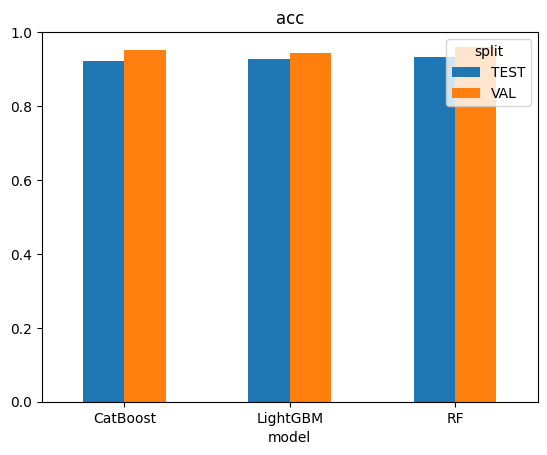

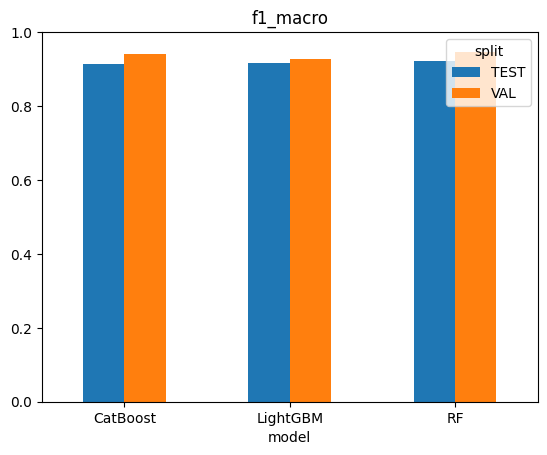

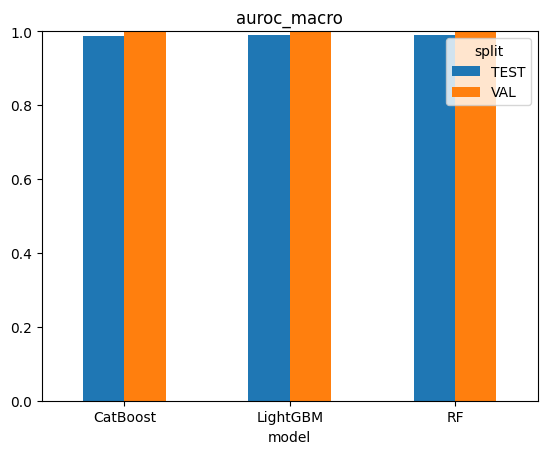

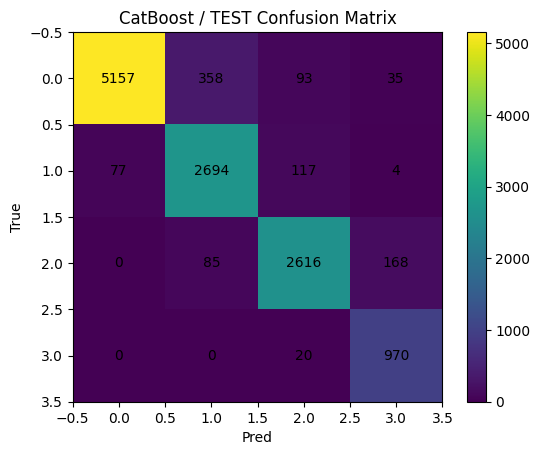

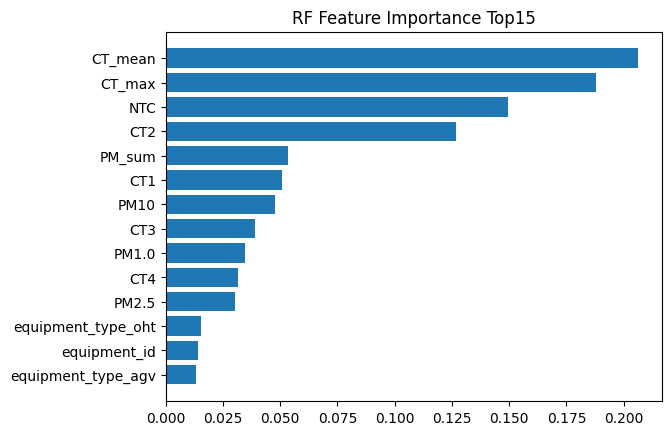

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# (1) 지표 바차트(VAL/TEST)
df_plot = pd.concat([
    df_val_sum.assign(split="VAL"),
    df_test_sum.assign(split="TEST")
], ignore_index=True)

for metric in ["acc","f1_macro","auroc_macro"]:
    pivot = df_plot.pivot(index="model", columns="split", values=metric)
    pivot.plot(kind="bar")
    plt.title(metric)
    plt.ylim(0,1.0)
    plt.xticks(rotation=0)
    plt.show()

# (2) 혼동행렬(예: CatBoost TEST)
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.colorbar()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j,i,cm[i,j],ha="center",va="center")
    plt.show()

plot_cm(y_test, pred_test_cat, "CatBoost / TEST Confusion Matrix")

import pandas as pd
import matplotlib.pyplot as plt

# ✅ RF가 실제 학습한 입력 컬럼 기준으로 맞추기
rf_cols = list(X_train_rf.columns)   # <-- (중요) 원핫 포함된 컬럼
assert len(rf.feature_importances_) == len(rf_cols), (len(rf.feature_importances_), len(rf_cols))

rf_fi = (
    pd.Series(rf.feature_importances_, index=rf_cols)
      .sort_values(ascending=False)
      .head(15)[::-1]
)

plt.figure()
plt.barh(rf_fi.index, rf_fi.values)
plt.title("RF Feature Importance Top15")
plt.show()

